## Imports

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
#%tensorflow_version 2.x
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout

## Define Model

In [ ]:
class ConvNet(Model):

    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = Conv2D(filters=16,kernel_size=2,padding="same",activation="relu",input_shape=(50,50,3))
        self.max_pool1 = MaxPooling2D(pool_size=2)
        self.conv2 = Conv2D(filters=32,kernel_size=2,padding="same",activation="relu")
        self.max_pool2 = MaxPooling2D(pool_size=2)
        self.conv3 = Conv2D(filters=64,kernel_size=2,padding="same",activation="relu")
        self.max_pool3 = MaxPooling2D(pool_size=2)
        self.drop1 = Dropout(0.2)
        self.flatten = Flatten()
        self.dense1 = Dense(500,activation="relu")
        self.drop2 = Dropout(0.2)
        self.dense2 = Dense(2,activation="softmax")

    @tf.function
    def call(self, x):
        x = self.conv1(x)
        x = self.max_pool1(x)
        x = self.conv2(x)
        x = self.max_pool2(x)
        x = self.conv3(x)
        x = self.max_pool3(x)
        x = self.drop1(x)
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.drop2(x)
        x = self.dense2(x)
        return x

## Load dataset

In [ ]:
# take first train_perc% for train_data, last 100-train_perc% for test_data
train_perc = 80

train_data, test_data = tfds.load(
    'malaria', split=['train[:{}%]'.format(train_perc), 'train[:{}%]'.format(100-train_perc)], 
    as_supervised=True)

## Inspect data set

[TensorShape([103, 103, 3]), TensorShape([106, 121, 3]), TensorShape([139, 142, 3]), TensorShape([130, 118, 3]), TensorShape([121, 109, 3]), TensorShape([127, 121, 3]), TensorShape([166, 151, 3]), TensorShape([145, 139, 3]), TensorShape([139, 142, 3]), TensorShape([172, 145, 3])]


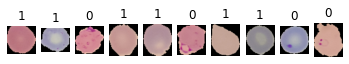

In [ ]:
fig, ax = plt.subplots(1,10)
shapes = []

for i, (img, lbl) in enumerate(train_data):
    if i == 10:
        break
    ax[i].imshow(img, cmap='gray')
    ax[i].set_title(lbl.numpy())
    ax[i].axis("off")
    shapes.append(img.shape)

print(shapes)    

## Define some constants

In [ ]:
# arbitrarily set. Feel free to change these
PREFETCH_SIZE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 128

## Prepare data

In [ ]:
def process_inp_and_label(input, label):
    """ resize inputs and onehotify labels """
    new_input = input / 255
    new_input = tf.image.resize(new_input, [50,50])
    return new_input, tf.one_hot(label, 2)

def data_pipeline(data):
    """ helper function for data pipeline - does all the things we need """
    data = data.map(process_inp_and_label)
    data = data.batch(BATCH_SIZE)
    data = data.shuffle(buffer_size=BATCH_SIZE)
    data = data.prefetch(PREFETCH_SIZE)
    return data

train_data = data_pipeline(train_data)
test_data = data_pipeline(test_data)

## Define helper functions

In [ ]:
def train_step(model, input, target, loss_function, optimizer):
    accuracy = None

    # loss_object and optimizer_object are instances of respective tensorflow classes
    with tf.GradientTape() as tape:
        prediction = model(input)
        accuracy = np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
        loss = loss_function(target, prediction)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    accuracy = np.mean(accuracy)

    return loss, accuracy

def test(model, test_data, loss_function):
    # test over complete test data

    test_accuracy_aggregator = []
    test_loss_aggregator = []

    for (input, target) in test_data:
        prediction = model(input)
        sample_test_loss = loss_function(target, prediction)
        sample_test_accuracy = np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
        sample_test_accuracy = np.mean(sample_test_accuracy)
        test_loss_aggregator.append(sample_test_loss.numpy())
        test_accuracy_aggregator.append(sample_test_accuracy)

    test_loss = np.mean(test_loss_aggregator)
    test_accuracy = np.mean(test_accuracy_aggregator)

    return test_loss, test_accuracy

def plot_stats(train_stat, test_stat, stat_name):
    plt.figure()
    line1, = plt.plot(train_stat)
    line2, = plt.plot(test_stat)
    plt.xlabel("Training steps")
    plt.ylabel(stat_name)
    plt.legend((line1, line2), ("training", "test"))
    plt.show()

In [ ]:
tf.keras.backend.clear_session()

## Prepare for training

In [ ]:
num_epochs = 10
learning_rate = 0.001
# set to 0 if you want to use mean instead of running average
running_average_factor = 0
loss = tf.keras.losses.BinaryCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate)
model = ConvNet()

# define calc_stat here to access running_average_factor
def calc_stat(stat_so_far, new_stat, stat_num):
    """Calculates appropriate statistic

    :param stat_so_far: the statistic that we have observed so far
    :param new_stat: the newest observed statistic
    :param stat_num: new_stat is the stat_num-th observed statistic
    :return: if 0, return mean, else running average
    """

    if running_average_factor:
        return running_average_factor * stat_so_far + (1 - running_average_factor) * new_stat
    # calculate mean of observed statistics so far
    return ((stat_num - 1) * stat_so_far + new_stat) / stat_num

# Initialize lists for later visualization.
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

##Train

In [ ]:
for epoch in range(num_epochs):
    print('Epoch: ' + str(epoch+1))

    # shuffle train data. No need to shuffle test data
    train_data = train_data.shuffle(buffer_size=BATCH_SIZE)

    train_loss_stat = 0
    train_accuracy_stat = 0
    for i, (input, target) in enumerate(train_data):
        train_loss, train_accuracy = train_step(model, input, target, loss, optimizer)
        train_loss_stat = calc_stat(train_loss_stat, train_loss, i+1)
        train_accuracy_stat = calc_stat(train_accuracy_stat, train_accuracy, i+1)
    train_losses.append(train_loss_stat)
    train_accuracies.append(train_accuracy_stat)

    # testing
    test_loss, test_accuracy = test(model, test_data, loss)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10


##Plot

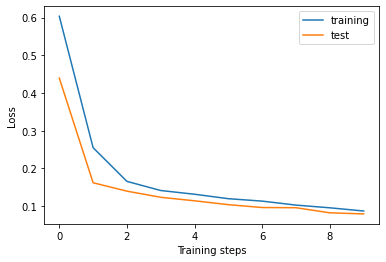

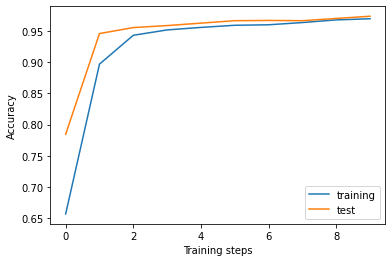

In [ ]:
plot_stats(train_losses, test_losses, "Loss")
plot_stats(train_accuracies, test_accuracies, "Accuracy")

## Assert over 95%

In [ ]:
assert test_accuracies[-1] >= 0.95
print(test_accuracies)

[0.7846235795454546, 0.9456676136363636, 0.9552556818181818, 0.9584517045454546, 0.9623579545454546, 0.9662642045454546, 0.9666193181818182, 0.9662642045454546, 0.9698153409090909, 0.9733664772727273]
